In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pathlib

from PIL import Image               # For reading image
from tqdm.notebook import trange    # For showing progress bar

%matplotlib inline

In [2]:
# All CONSTANTS used in the notebook
# Set the path to the Test Image
PATH = pathlib.Path('~/Downloads').expanduser() # Path to image folder
LEFT_IMAGE = PATH / 'HW1-left-gray.png'
RIGHT_IMAGE = PATH / 'HW1-right-gray.png'

K = 10                         # number of distinct disparity values
RANGE = list(range(K))         # list of possible disparity values
SIGMA_SQ = (1/300)**2          # square of sigma hyperparameter
GAMMA_SQ = (1)**2              # square of gamma hyperparameter
DELTA_0 = 3                    # d0 value
PHI_ST = np.zeros(())          # array to store precomputations of phi_st
PHI_S = np.zeros(())           # array to store the precomputation of phi_s


In [3]:
def read_image(path: pathlib.Path):
    """Reads image from the given Path
    
    Returns: `np.ndarray`, matrix of Image
    """
    return Image.open(path).convert("L")

def neighbours(S: (int, int)):
    """
    Returns neighbour coordinates of S
    """
    (s1, s2) = S
    return [(s1+1, s2), (s1-1, s2), (s1, s2+1), (s1, s2-1),
            (s1+1, s2+1), (s1-1, s2-1), (s1+1, s2-1), (s1-1, s2+1)]

def phi_st(ds, dt):
    """
    Returns the phi(ds, dt) for two disparity values
    """
    return PHI_ST[ds, dt]


def phi_s(S: (int, int), df):
    """
    Returns phi_s(df) at S.
    """
    (s1, s2) = S
    return PHI_S[s1, s2, df]


def M_ts(T: (int, int), S, ds):
    """
    Message from T to S when Xs is equal to ds
    """
    temp = 0
    for dt in RANGE:
        temp += phi_st(ds, dt) * prob(dt, T)
    return temp


def prob(dt, T: (int, int)):
    """
    Returns probaility that random variable at T takes value dt given that T is
    a root node of a tree containing only itself.
    """
    return phi_s(T, dt)  # phi_s because this node is a leaf node.

In [4]:
def Marginal(S: (int, int)):
    """
    Calculates marginal for random varible at S
    Returns K probability values one each possible disparity value.
    """
    (s1, s2) = S
    vals = []
    for ds in RANGE:
        temp = phi_s(S, ds)
        for T in neighbours(S):
            temp *= M_ts(T, S, ds)
        vals.append(temp)
    vals = np.array(vals)
    vals = vals / (np.sum(vals)+0.000000001)
    return vals

In [5]:
def initialize():
    """
    Initialize the global arrays with precomputed values.
    """
    global PHI_S, PHI_ST
    PHI_ST = np.zeros((K, K))
    PHI_S = np.zeros((right.shape[0], right.shape[0], 10))

    def PHI_st(ds, dt):
        """
        Calculate the phi_st to store in the array
        """
        temp = -1 * (0.5 / GAMMA_SQ)
        temp = temp * min((ds - dt) ** 2, (DELTA_0)**2)
        return math.exp(temp)

    def PHI_s(S: (int, int), df):
        """
        Calculate the phi_s to store in the array
        """
        (s1, s2) = S
        temp = -1 * (0.5 / SIGMA_SQ)
        temp = temp * ((left[s1, s2] - right[s1 + df, s2]) ** 2)
        return math.exp(temp)

    # Initialize PHI_ST
    for i in RANGE:
        for j in RANGE:
            PHI_ST[i, j] = PHI_st(i, j)

    # Initialize PHI_S
    for i in range(right.shape[0]-2*10):
        for j in range(right.shape[0]-2*10):
            for df in RANGE:
                PHI_S[i+10, j+10, df] = PHI_s((i+10, j+10), df)

In [6]:
# Read and normalize image
left_image = read_image(LEFT_IMAGE)
right_image = read_image(RIGHT_IMAGE)
left, right = np.array(left_image)/255, np.array(right_image)/255

# Precomputation
initialize()
# No of pixels to skip from border.
n = 10
disparity = np.zeros((right.shape[0]-2*n, right.shape[0]-2*n, 10))
for i in trange(right.shape[0]-2*n):
    for j in range(right.shape[0]-2*n):
        disparity[i, j, :] = Marginal((i+n, j+n))

# Argmax of disparity
answers = np.argmax(disparity, 2)

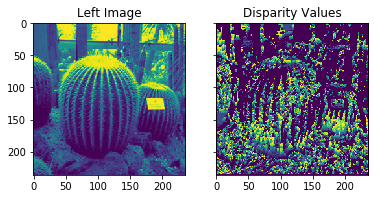

In [7]:
# Plotting the disparity map and Left image view
image = left[10:-10, 10:-10]
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.imshow(image)
ax1.set_title('Left Image')
ax2.imshow(answers)
ax2.set_title('Disparity Values')
plt.show()